In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Dim reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# clustering
import seaborn as sns
from IPython.display import display, Image

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

# set the working directory
wd = '/Users/masaver/Desktop/masaver/job_applications/TUM/bioinf/case_study/code'
os.chdir( wd )

## Data Wrangling
In the first section of this notebook I will parse the data into te appropiate format, as requiered for subsequent analysis

In [2]:
# Read the Clinical metadata & display a preview
metadata_path = '../data/S053_S043_CPTAC_UCEC_Discovery_Cohort_Clinical_Data_r2_Feb2020.xlsx' 
clinical_data = pd.read_excel( metadata_path , sheet_name = 'Patient_Clinical_Attributes' )
clinical_data.head()

,tumor_code,case_id,case_excluded,type_of_analyzed_samples,age,gender,height_at_time_of_surgery_cm,height_at_time_of_surgery_inch,weight_at_time_of_surgery_kg,weight_at_time_of_surgery_lb,...,cause_of_death_at_24months_follow_up,days_from_date_of_initial_pathologic_diagnosis_to_date_of_death_at_12months_follow_up,days_from_date_of_initial_pathologic_diagnosis_to_date_of_death_at_24months_follow_up,days_from_date_of_initial_pathologic_diagnosis_to_date_of_death_at_36months_follow_up,days_from_date_of_initial_pathologic_diagnosis_to_date_of_additional_surgery_for_new_tumor_at_12months_follow_up,days_from_date_of_initial_pathologic_diagnosis_to_date_of_additional_surgery_for_new_tumor_at_24months_follow_up,procedure_type_of_new_tumor_at_12months_follow_up,procedure_type_of_new_tumor_at_24months_follow_up,residual_tumor_after_sugery_for_new_tumor_at_12months_follow_up,residual_tumor_after_sugery_for_new_tumor_at_24months_follow_up
0,UCEC,C3L-00006,No,Tumor_and_Normal,64,Female,152,60,90,199,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,UCEC,C3L-00008,No,Tumor,58,Female,162,64,105,231,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,UCEC,C3L-00032,No,Tumor,50,Female,163,64,136,300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,UCEC,C3L-00084,Yes,Tumor,74,Female,162,64,130,287,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,UCEC,C3L-00090,No,Tumor,75,Female,165,65,89,196,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# check for NAs on the clinical data
ix = np.where( clinical_data.isna().sum() > 0 )[0]
print( f"Columns with NAs: {len(ix)}" )

Columns with NAs: 100


In [4]:
# Print the columns with the most NAs
clinical_data.isna().sum().sort_values(ascending=False).head(25)

residual_tumor_after_sugery_for_new_tumor_at_24months_follow_up                                                      102
procedure_type_of_new_tumor_at_24months_follow_up                                                                    102
days_from_date_of_initial_pathologic_diagnosis_to_date_of_additional_surgery_for_new_tumor_at_24months_follow_up     102
days_from_date_of_initial_pathologic_diagnosis_to_date_of_death_at_36months_follow_up                                102
exposure_to_secondhand_smoke_in_household_during_participants_childhood                                              102
residual_tumor_after_sugery_for_new_tumor_at_12months_follow_up                                                      101
procedure_type_of_new_tumor_at_12months_follow_up                                                                    101
days_from_date_of_initial_pathologic_diagnosis_to_date_of_additional_surgery_for_new_tumor_at_12months_follow_up     101
days_from_date_of_initial_pathol

In [5]:
# Read and display the protein groups .txt file
protein_groups_path = '../data/proteinGroups.txt'
protein_groups = pd.read_csv( protein_groups_path , sep = '\t' , index_col = 0 )
print( protein_groups.shape)
protein_groups.head()

(12020, 654)


,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Protein names,Gene names,Fasta headers,Number of proteins,Peptides,Razor + unique peptides,...,id,Peptide IDs,Peptide is razor,Mod. peptide IDs,Evidence IDs,MS/MS IDs,Best MS/MS,Oxidation (M) site IDs,Oxidation (M) site positions,Taxonomy IDs
Protein IDs,,,,,,,,,,,,,,,,,,,,,
A0A024RBG1,A0A024RBG1,11,2,2,NaN,NUDT4,sp|A0A024RBG1|NUD4B_HUMAN Diphosphoinositol po...,1,11,2,...,0,373;58394;62439;110264;114790;114791;147426;17...,False;False;False;False;True;True;False;False;...,399;62739;67075;118378;123220;123221;160283;18...,4916;4917;4918;4919;4920;4921;4922;4923;4924;4...,5620;5621;5622;5623;5624;5625;5626;5627;5628;5...,5639;886923;953424;1686987;1755456;1755466;225...,0,53,-1
A0A075B6H9;A0A075B6K6,A0A075B6H9,3;1,2;0,2;0,NaN,IGLV4-69,sp|A0A075B6H9|LV469_HUMAN Immunoglobulin lambd...,2,3,2,...,1,65168;68849;68850,True;False;True,70043;73970;73971,869176;869177;869178;869179;869180;869181;8691...,996417;996418;996419;996420;996421;996422;9964...,996436;1055341;1055346,NaN,NaN,-1;-1
A0A075B6I0,A0A075B6I0,4,4,4,NaN,IGLV8-61,sp|A0A075B6I0|LV861_HUMAN Immunoglobulin lambd...,1,4,4,...,2,65163;180232;180233;190758,True;True;True;True,70038;195264;195265;206513,869077;869078;869079;869080;869081;869082;8690...,996314;996315;996316;996317;996318;996319;9963...,996334;2708251;2708258;2866834,NaN,NaN,-1
A0A075B6I1,A0A075B6I1,2,2,2,NaN,IGLV4-60,sp|A0A075B6I1|LV460_HUMAN Immunoglobulin lambd...,1,2,2,...,3,65167;78824,True;True,70042;84742,869161;869162;869163;869164;869165;869166;8691...,996401;996402;996403;996404;996405;996406;9964...,996410;1210952,NaN,NaN,-1
A0A075B6I4,A0A075B6I4,1,1,1,NaN,IGLV10-54,sp|A0A075B6I4|LVX54_HUMAN Immunoglobulin lambd...,1,1,1,...,4,139386,True,151716,1876348;1876349;1876350,2145644;2145645;2145646,2145646,NaN,NaN,-1


In [6]:
# Subset only the columns with the corrected intensity
data_cols = [c for c in protein_groups.columns if "Reporter intensity corrected" in c]
dfs = protein_groups[data_cols]
dfs

,Reporter intensity corrected 1 01CPTAC_UCEC_Proteome_PNNL_20170922_01CPTAC_UCEC_Proteome_PNNL_20170922_raw,Reporter intensity corrected 2 01CPTAC_UCEC_Proteome_PNNL_20170922_01CPTAC_UCEC_Proteome_PNNL_20170922_raw,Reporter intensity corrected 3 01CPTAC_UCEC_Proteome_PNNL_20170922_01CPTAC_UCEC_Proteome_PNNL_20170922_raw,Reporter intensity corrected 4 01CPTAC_UCEC_Proteome_PNNL_20170922_01CPTAC_UCEC_Proteome_PNNL_20170922_raw,Reporter intensity corrected 5 01CPTAC_UCEC_Proteome_PNNL_20170922_01CPTAC_UCEC_Proteome_PNNL_20170922_raw,Reporter intensity corrected 6 01CPTAC_UCEC_Proteome_PNNL_20170922_01CPTAC_UCEC_Proteome_PNNL_20170922_raw,Reporter intensity corrected 7 01CPTAC_UCEC_Proteome_PNNL_20170922_01CPTAC_UCEC_Proteome_PNNL_20170922_raw,Reporter intensity corrected 8 01CPTAC_UCEC_Proteome_PNNL_20170922_01CPTAC_UCEC_Proteome_PNNL_20170922_raw,Reporter intensity corrected 9 01CPTAC_UCEC_Proteome_PNNL_20170922_01CPTAC_UCEC_Proteome_PNNL_20170922_raw,Reporter intensity corrected 10 01CPTAC_UCEC_Proteome_PNNL_20170922_01CPTAC_UCEC_Proteome_PNNL_20170922_raw,...,Reporter intensity corrected 1 17CPTAC_UCEC_Proteome_PNNL_20181015_17CPTAC_UCEC_Proteome_PNNL_20181015_raw,Reporter intensity corrected 2 17CPTAC_UCEC_Proteome_PNNL_20181015_17CPTAC_UCEC_Proteome_PNNL_20181015_raw,Reporter intensity corrected 3 17CPTAC_UCEC_Proteome_PNNL_20181015_17CPTAC_UCEC_Proteome_PNNL_20181015_raw,Reporter intensity corrected 4 17CPTAC_UCEC_Proteome_PNNL_20181015_17CPTAC_UCEC_Proteome_PNNL_20181015_raw,Reporter intensity corrected 5 17CPTAC_UCEC_Proteome_PNNL_20181015_17CPTAC_UCEC_Proteome_PNNL_20181015_raw,Reporter intensity corrected 6 17CPTAC_UCEC_Proteome_PNNL_20181015_17CPTAC_UCEC_Proteome_PNNL_20181015_raw,Reporter intensity corrected 7 17CPTAC_UCEC_Proteome_PNNL_20181015_17CPTAC_UCEC_Proteome_PNNL_20181015_raw,Reporter intensity corrected 8 17CPTAC_UCEC_Proteome_PNNL_20181015_17CPTAC_UCEC_Proteome_PNNL_20181015_raw,Reporter intensity corrected 9 17CPTAC_UCEC_Proteome_PNNL_20181015_17CPTAC_UCEC_Proteome_PNNL_20181015_raw,Reporter intensity corrected 10 17CPTAC_UCEC_Proteome_PNNL_20181015_17CPTAC_UCEC_Proteome_PNNL_20181015_raw
Protein IDs,,,,,,,,,,,,,,,,,,,,,
A0A024RBG1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,61643.0,62006.0,78448.0,71128.0,74147.0,71708.0,55561.0,78696.0,104990.0,65165.0
A0A075B6H9;A0A075B6K6,95301.0,97608.0,126600.0,128180.0,272530.0,211580.0,274920.0,120680.0,168940.0,61900.0,...,31352.0,29710.0,80613.0,135250.0,40461.0,52336.0,96208.0,71705.0,83600.0,43615.0
A0A075B6I0,176590.0,524190.0,355940.0,196360.0,533040.0,278450.0,292460.0,288160.0,189440.0,139600.0,...,3791600.0,3058600.0,1292500.0,5740000.0,9970200.0,5707500.0,13644000.0,5664300.0,10451000.0,13328000.0
A0A075B6I1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,583810.0,1124700.0,1335800.0,2406700.0,2213400.0,1371200.0,2476400.0,1697900.0,3302200.0,1858200.0
A0A075B6I4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
REV__Q9Y617,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
REV__Q9Y6A2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
REV__Q9Y6E2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
( ( dfs == 0 ).sum( axis = 1 ) == dfs.shape[1] ).value_counts()

False    11914
True       106
Name: count, dtype: int64

In [8]:
( ( dfs > 0 ).sum( axis = 1 ) == dfs.shape[1] ).value_counts()

True     7377
False    4643
Name: count, dtype: int64

The previous cell shows that 106 entries/rows in the dataframe, aka ProteinGroups , were not detected at all in this set of measurements. Hence, I will proceed to remove them from the expression data

In [9]:
ix = np.where( ( ( dfs == 0 ).sum( axis = 1 ) != dfs.shape[1] ) )[0]
exp_data = dfs.iloc[ ix ]
print( exp_data.shape )


(11914, 170)


In [10]:
# function to normalize intensity values
channel_to_idx_dict = {
    '126': 1,
    '127N': 2,
    '127C': 3,
    '128N': 4,
    '128C': 5,
    '129N': 6,
    '129C': 7,
    '130N': 8,
    '130C': 9,
    '131': 10,
}

def normalize_intensity_by_reference(row, reference_channel, list_of_batches):

    """
    Normalizes intensity values in a dataset based on a reference channel for each batch.
    Intensities are scaled back to their original value range using the median of all reference intensity values.

    Parameters:
        row (pd.Series): The data row containing intensity values.
        reference_channel (str): The name of the reference channel to normalize by.
        list_of_batches (list): List of batch identifiers to process.

    Returns:
        pd.Series: The normalized intensity values for the row.
    """

    # Extract intensity values for the reference channel across all batches
    reference_values = row[row.index.str.startswith(f'Reporter intensity corrected {reference_channel} ')]

    # Remove zero values and calculate the median of the non-zero reference intensities
    non_zero_references = reference_values[reference_values != 0]
    reference_median = non_zero_references.median() if not non_zero_references.empty else 0

    # Create a mask to identify all channels starting with "Reporter intensity corrected"
    reporter_mask = row.index.str.startswith("Reporter intensity corrected ")

    # Initialize a dictionary to store the normalized values
    res_dict = row.to_dict()

    # Iterate through each batch
    for batch in list_of_batches:
        # Extract reference intensity for the current batch
        reference_col = f'Reporter intensity corrected {reference_channel} {batch}'
        reference_intensity = row.get(reference_col, 0)

        # Identify all channels for the current batch
        batch_channels_mask = reporter_mask & row.index.str.endswith(f" {batch}")
        batch_values = row[batch_channels_mask]

        # Normalize batch values using reference intensity, if non-zero
        if reference_intensity != 0:
            normalized_values = (batch_values / reference_intensity) * reference_median
        else:
            normalized_values = pd.Series(0, index=batch_values.index)

        # Update the result dictionary with the normalized values
        res_dict.update(normalized_values.to_dict())

    return pd.Series(res_dict)

In [11]:
# ReFormat the intensity col names, as expected in the norm funct
def split_by_separators(s, separators = [' ','_']):
    import re
    pattern = '|'.join(map(re.escape, separators))
    return re.split(pattern, s)

split_results = [split_by_separators(col) for col in exp_data.columns]
split_results_df = pd.DataFrame( split_results )
split_results_df[4] = split_results_df[4].str.replace('CPTAC', '', regex=False)
BATCHES = split_results_df[4].unique().tolist()
split_results_df['id'] = split_results_df[[0, 1, 2, 3, 4]].agg(' '.join, axis=1)
split_results_df.set_index('id', inplace=True)

# Rename columns in the intensity dataframe
exp_data.columns = split_results_df.index  
display( BATCHES )
display( exp_data )

# 


['01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17']

id,Reporter intensity corrected 1 01,Reporter intensity corrected 2 01,Reporter intensity corrected 3 01,Reporter intensity corrected 4 01,Reporter intensity corrected 5 01,Reporter intensity corrected 6 01,Reporter intensity corrected 7 01,Reporter intensity corrected 8 01,Reporter intensity corrected 9 01,Reporter intensity corrected 10 01,...,Reporter intensity corrected 1 17,Reporter intensity corrected 2 17,Reporter intensity corrected 3 17,Reporter intensity corrected 4 17,Reporter intensity corrected 5 17,Reporter intensity corrected 6 17,Reporter intensity corrected 7 17,Reporter intensity corrected 8 17,Reporter intensity corrected 9 17,Reporter intensity corrected 10 17
Protein IDs,,,,,,,,,,,,,,,,,,,,,
A0A024RBG1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,61643.0,62006.0,78448.0,71128.0,74147.0,71708.0,55561.0,78696.0,104990.0,65165.0
A0A075B6H9;A0A075B6K6,95301.0,97608.0,126600.0,128180.0,272530.0,211580.0,274920.0,120680.0,168940.0,61900.0,...,31352.0,29710.0,80613.0,135250.0,40461.0,52336.0,96208.0,71705.0,83600.0,43615.0
A0A075B6I0,176590.0,524190.0,355940.0,196360.0,533040.0,278450.0,292460.0,288160.0,189440.0,139600.0,...,3791600.0,3058600.0,1292500.0,5740000.0,9970200.0,5707500.0,13644000.0,5664300.0,10451000.0,13328000.0
A0A075B6I1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,583810.0,1124700.0,1335800.0,2406700.0,2213400.0,1371200.0,2476400.0,1697900.0,3302200.0,1858200.0
A0A075B6I4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
REV__Q9Y5X9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
REV__Q9Y617,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
REV__Q9Y6A2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# Normalize the Intensity data
exp_data_n = exp_data.apply( 
    normalize_intensity_by_reference , 
    axis = 1 , 
    reference_channel = '1' , 
    list_of_batches = BATCHES  
    )

#Log-Transform the data
exp_data_n = np.log1p( exp_data_n)

display( exp_data )
display( exp_data_n )


id,Reporter intensity corrected 1 01,Reporter intensity corrected 2 01,Reporter intensity corrected 3 01,Reporter intensity corrected 4 01,Reporter intensity corrected 5 01,Reporter intensity corrected 6 01,Reporter intensity corrected 7 01,Reporter intensity corrected 8 01,Reporter intensity corrected 9 01,Reporter intensity corrected 10 01,...,Reporter intensity corrected 1 17,Reporter intensity corrected 2 17,Reporter intensity corrected 3 17,Reporter intensity corrected 4 17,Reporter intensity corrected 5 17,Reporter intensity corrected 6 17,Reporter intensity corrected 7 17,Reporter intensity corrected 8 17,Reporter intensity corrected 9 17,Reporter intensity corrected 10 17
Protein IDs,,,,,,,,,,,,,,,,,,,,,
A0A024RBG1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,61643.0,62006.0,78448.0,71128.0,74147.0,71708.0,55561.0,78696.0,104990.0,65165.0
A0A075B6H9;A0A075B6K6,95301.0,97608.0,126600.0,128180.0,272530.0,211580.0,274920.0,120680.0,168940.0,61900.0,...,31352.0,29710.0,80613.0,135250.0,40461.0,52336.0,96208.0,71705.0,83600.0,43615.0
A0A075B6I0,176590.0,524190.0,355940.0,196360.0,533040.0,278450.0,292460.0,288160.0,189440.0,139600.0,...,3791600.0,3058600.0,1292500.0,5740000.0,9970200.0,5707500.0,13644000.0,5664300.0,10451000.0,13328000.0
A0A075B6I1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,583810.0,1124700.0,1335800.0,2406700.0,2213400.0,1371200.0,2476400.0,1697900.0,3302200.0,1858200.0
A0A075B6I4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
REV__Q9Y5X9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
REV__Q9Y617,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
REV__Q9Y6A2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,Reporter intensity corrected 1 01,Reporter intensity corrected 2 01,Reporter intensity corrected 3 01,Reporter intensity corrected 4 01,Reporter intensity corrected 5 01,Reporter intensity corrected 6 01,Reporter intensity corrected 7 01,Reporter intensity corrected 8 01,Reporter intensity corrected 9 01,Reporter intensity corrected 10 01,...,Reporter intensity corrected 1 17,Reporter intensity corrected 2 17,Reporter intensity corrected 3 17,Reporter intensity corrected 4 17,Reporter intensity corrected 5 17,Reporter intensity corrected 6 17,Reporter intensity corrected 7 17,Reporter intensity corrected 8 17,Reporter intensity corrected 9 17,Reporter intensity corrected 10 17
Protein IDs,,,,,,,,,,,,,,,,,,,,,
A0A024RBG1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,11.513215,11.519087,11.754290,11.656335,11.697904,11.664457,11.409338,11.757446,12.045717,11.568778
A0A075B6H9;A0A075B6K6,12.633726,12.657645,12.917718,12.930121,13.684433,13.431288,13.693164,12.869828,13.206228,12.202208,...,12.633726,12.579932,13.578106,14.095571,12.888786,13.146132,13.754959,13.461007,13.614490,12.963849
A0A075B6I0,13.462473,14.550496,14.163404,13.568592,14.567238,13.917881,13.966970,13.952158,13.532715,13.227424,...,13.462473,13.247643,12.386266,13.877144,14.429285,13.871466,14.742984,13.863868,14.476382,14.719551
A0A075B6I1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,12.298246,12.953940,13.125954,13.714679,13.630952,13.152109,13.743228,13.365815,14.031011,13.456031
A0A075B6I4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
REV__Q9Y5X9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
REV__Q9Y617,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
REV__Q9Y6A2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Next, I will proceed to create a metadata table requiered for the upcomming analysis

In [13]:
# read the clinical metadata
metadata_path = '../data/S053_S043_CPTAC_UCEC_Discovery_Cohort_Clinical_Data_r2_Feb2020.xlsx'
metadata = pd.read_excel( metadata_path , sheet_name = 'Patient_Clinical_Attributes' )
metadata

,tumor_code,case_id,case_excluded,type_of_analyzed_samples,age,gender,height_at_time_of_surgery_cm,height_at_time_of_surgery_inch,weight_at_time_of_surgery_kg,weight_at_time_of_surgery_lb,...,cause_of_death_at_24months_follow_up,days_from_date_of_initial_pathologic_diagnosis_to_date_of_death_at_12months_follow_up,days_from_date_of_initial_pathologic_diagnosis_to_date_of_death_at_24months_follow_up,days_from_date_of_initial_pathologic_diagnosis_to_date_of_death_at_36months_follow_up,days_from_date_of_initial_pathologic_diagnosis_to_date_of_additional_surgery_for_new_tumor_at_12months_follow_up,days_from_date_of_initial_pathologic_diagnosis_to_date_of_additional_surgery_for_new_tumor_at_24months_follow_up,procedure_type_of_new_tumor_at_12months_follow_up,procedure_type_of_new_tumor_at_24months_follow_up,residual_tumor_after_sugery_for_new_tumor_at_12months_follow_up,residual_tumor_after_sugery_for_new_tumor_at_24months_follow_up
0,UCEC,C3L-00006,No,Tumor_and_Normal,64,Female,152,60,90,199,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,UCEC,C3L-00008,No,Tumor,58,Female,162,64,105,231,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,UCEC,C3L-00032,No,Tumor,50,Female,163,64,136,300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,UCEC,C3L-00084,Yes,Tumor,74,Female,162,64,130,287,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,UCEC,C3L-00090,No,Tumor,75,Female,165,65,89,196,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,UCEC,C3N-01520,No,Tumor,69,Female,164,65,79,174,...,Non-oncology condition,NaN,286.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99,UCEC,C3N-01521,No,Tumor,75,Female,167,66,82,181,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,UCEC,C3N-01537,No,Tumor,74,Female,154,61,84,185,...,NaN,NaN,NaN,NaN,61.0,61.0,Surgical Resection,Surgical Resection,RX,RX
101,UCEC,C3N-01802,No,Tumor,85,Female,163,64,64,142,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# TMplex & Participant ids
ids_path = '../data/S053_S043_CPTAC_UCEC_Discovery_Cohort_Study_Specimens_r2_Feb2020.xlsx'
ids = pd.read_excel( ids_path , sheet_name = 'metadata' )
ids['TMT channel'] = ids['TMT channel'].astype(str)
ids

,TMT plex,TMT channel,ParticipantID (Case_ID)
0,1,126,Ref
1,1,127N,C3N-00858
2,1,127C,C3N-00858
3,1,128N,C3L-01252
4,1,128C,C3L-01252
...,...,...,...
165,17,129N,NX10
166,17,129C,NX16
167,17,130N,NX18
168,17,130C,NX11


In [15]:
# invert the channel to index dictionary
idx_to_channel_dict = {v: k for k, v in channel_to_idx_dict.items()}
idx_to_channel_dict

{1: '126',
 2: '127N',
 3: '127C',
 4: '128N',
 5: '128C',
 6: '129N',
 7: '129C',
 8: '130N',
 9: '130C',
 10: '131'}

In [16]:
def get_case_id( x ):
    split_str = x.split()
    tmt_channel = idx_to_channel_dict[ int(split_str[3]) ]
    tmt_plex = int( split_str[4] )

    # find the relevant ix on the ids table
    ix = np.where( (ids['TMT plex'] == tmt_plex) & ( ids['TMT channel'] == str(tmt_channel) ) )
    ix = ix[0]
    sample_id = ids['ParticipantID (Case_ID)'].iloc[ix].values[0]

    return [tmt_channel , tmt_plex , sample_id]
 
colData = []
for col in exp_data.columns:
    colData.append( get_case_id(col) )

colData = pd.DataFrame( colData , columns = ['TMT channel' , 'TMT plex' , 'Case ID'] )
colData['SampleName'] = exp_data_n.columns.tolist()

# remove non-Ref samples from the Norm data and colData tables
ix_nonRef = np.where( colData['Case ID'] != 'Ref' )[0]
colData = colData.iloc[ix_nonRef , :].reset_index( drop = True )
exp_data = exp_data_n.iloc[:, ix_nonRef ]

# extract the TMT channel suffix
colData['TMT channel suffix'] = colData['TMT channel'].astype(str).str[-1]

# Add metadata from the clinical data table
ix = [ np.where( metadata['case_id'] == cid )[0] for cid in colData['Case ID'] ]
ix_flat = [i[0] if len(i) > 0 else None for i in ix]
ix_flat = [i for i in ix_flat if i is not None]
colData = colData.join( metadata[['age','tumor_stage_pathological','histologic_type']].iloc[ix_flat].reset_index( drop = True ) )


print( colData.isna().sum() )
display( colData )


TMT channel                  0
TMT plex                     0
Case ID                      0
SampleName                   0
TMT channel suffix           0
age                         23
tumor_stage_pathological    23
histologic_type             23
dtype: int64


,TMT channel,TMT plex,Case ID,SampleName,TMT channel suffix,age,tumor_stage_pathological,histologic_type
0,127N,1,C3N-00858,Reporter intensity corrected 2 01,N,65,Stage III,Endometrioid carcinoma
1,127C,1,C3N-00858,Reporter intensity corrected 3 01,C,65,Stage III,Endometrioid carcinoma
2,128N,1,C3L-01252,Reporter intensity corrected 4 01,N,76,Stage I,Endometrioid carcinoma
3,128C,1,C3L-01252,Reporter intensity corrected 5 01,C,76,Stage I,Endometrioid carcinoma
4,129N,1,C3L-00947,Reporter intensity corrected 6 01,N,71,Stage I,Endometrioid carcinoma
...,...,...,...,...,...,...,...,...
148,129N,17,NX10,Reporter intensity corrected 6 17,N,NaN,NaN,NaN
149,129C,17,NX16,Reporter intensity corrected 7 17,C,NaN,NaN,NaN
150,130N,17,NX18,Reporter intensity corrected 8 17,N,NaN,NaN,NaN
151,130C,17,NX11,Reporter intensity corrected 9 17,C,NaN,NaN,NaN


In [17]:
colData['age'].tolist()

[65,
 65,
 76,
 76,
 71,
 71,
 53,
 42,
 65,
 64,
 64,
 65,
 65,
 61,
 61,
 64,
 50,
 62,
 62,
 55,
 55,
 75,
 75,
 '>=90',
 64,
 62,
 74,
 74,
 64,
 64,
 68,
 68,
 64,
 70,
 67,
 65,
 65,
 64,
 64,
 56,
 56,
 38,
 56,
 59,
 57,
 57,
 86,
 86,
 50,
 50,
 63,
 75,
 45,
 62,
 62,
 71,
 71,
 69,
 58,
 78,
 68,
 77,
 77,
 67,
 67,
 59,
 59,
 57,
 45,
 59,
 73,
 73,
 72,
 72,
 41,
 65,
 73,
 44,
 59,
 59,
 59,
 63,
 60,
 70,
 57,
 64,
 64,
 77,
 86,
 86,
 62,
 62,
 73,
 83,
 66,
 73,
 73,
 53,
 58,
 69,
 75,
 61,
 62,
 56,
 63,
 63,
 59,
 74,
 60,
 60,
 46,
 77,
 75,
 63,
 68,
 64,
 69,
 53,
 65,
 66,
 56,
 53,
 60,
 66,
 48,
 85,
 60,
 50,
 58,
 65,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

For further analysis I selected **age**, **tumor_stage_pathological** & **histological_type**. The previous cell also shows that there are 23 measurements for which this metadata is not available, and to facilitate subsequent analysis I will remove them

In [18]:
colData = colData.dropna().reset_index(drop=True)
print( colData.isna().sum() )

# Subset the expression data
exp_data_n = exp_data_n[ colData.SampleName ]

# Convert age to a categorical variable based on the median
def get_age_cat(x):
    age_vals = colData['age'].tolist()
    age_vals = [a for a in age_vals if a != '>=90']
    age_median = np.median( age_vals )

    if x == '>=90':
        return 'group_h'
    elif x > age_median:
        return 'group_h'
    elif x <= age_median:
        return 'group_l'

colData['age_cat'] = colData['age'].apply( get_age_cat )

# display previews of the final tables
display( colData )
display( exp_data_n )


TMT channel                 0
TMT plex                    0
Case ID                     0
SampleName                  0
TMT channel suffix          0
age                         0
tumor_stage_pathological    0
histologic_type             0
dtype: int64


,TMT channel,TMT plex,Case ID,SampleName,TMT channel suffix,age,tumor_stage_pathological,histologic_type,age_cat
0,127N,1,C3N-00858,Reporter intensity corrected 2 01,N,65,Stage III,Endometrioid carcinoma,group_h
1,127C,1,C3N-00858,Reporter intensity corrected 3 01,C,65,Stage III,Endometrioid carcinoma,group_h
2,128N,1,C3L-01252,Reporter intensity corrected 4 01,N,76,Stage I,Endometrioid carcinoma,group_h
3,128C,1,C3L-01252,Reporter intensity corrected 5 01,C,76,Stage I,Endometrioid carcinoma,group_h
4,129N,1,C3L-00947,Reporter intensity corrected 6 01,N,71,Stage I,Endometrioid carcinoma,group_h
...,...,...,...,...,...,...,...,...,...
125,131,14,C3N-01510,Reporter intensity corrected 10 14,1,85,Stage II,Serous carcinoma,group_h
126,127N,15,C3L-01925,Reporter intensity corrected 2 15,N,60,Stage I,Endometrioid carcinoma,group_l
127,127C,15,NX5,Reporter intensity corrected 3 15,C,50,Stage I,Endometrioid carcinoma,group_l
128,128N,15,NX6,Reporter intensity corrected 4 15,N,58,Stage I,Endometrioid carcinoma,group_l


,Reporter intensity corrected 2 01,Reporter intensity corrected 3 01,Reporter intensity corrected 4 01,Reporter intensity corrected 5 01,Reporter intensity corrected 6 01,Reporter intensity corrected 7 01,Reporter intensity corrected 8 01,Reporter intensity corrected 9 01,Reporter intensity corrected 10 01,Reporter intensity corrected 2 02,...,Reporter intensity corrected 5 14,Reporter intensity corrected 6 14,Reporter intensity corrected 7 14,Reporter intensity corrected 8 14,Reporter intensity corrected 9 14,Reporter intensity corrected 10 14,Reporter intensity corrected 2 15,Reporter intensity corrected 3 15,Reporter intensity corrected 4 15,Reporter intensity corrected 5 15
Protein IDs,,,,,,,,,,,,,,,,,,,,,
A0A024RBG1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,11.751450,11.942361,11.568283,11.303858,11.565977,12.037491,0.000000,0.000000,0.000000,0.000000
A0A075B6H9;A0A075B6K6,12.657645,12.917718,12.930121,13.684433,13.431288,13.693164,12.869828,13.206228,12.202208,12.291145,...,10.415959,12.062970,12.951164,12.910331,11.717572,12.422523,11.952204,13.118531,13.257058,11.931183
A0A075B6I0,14.550496,14.163404,13.568592,14.567238,13.917881,13.966970,13.952158,13.532715,13.227424,13.731438,...,12.377531,12.688399,13.247399,13.031704,13.863421,14.102161,12.949684,14.012585,13.723913,12.257038
A0A075B6I1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.408821,...,11.383188,12.918174,12.243901,12.824207,12.012544,11.919384,11.665613,11.928257,12.668433,12.202260
A0A075B6I4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.031578,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
REV__Q9Y5X9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
REV__Q9Y617,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.447672,10.714862,11.090507,10.866986
REV__Q9Y6A2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,12.976883,10.687504,10.903891,12.209341,9.863623,12.250489,0.000000,0.000000,0.000000,0.000000


## Pre-processing summary
The main steps for pre-processing/parsing the data are:
* 7377 entries/rows in the dataframe, aka ProteinGroups , were removed since they represent proteins not detected in any sample
* The resulting expression data was median normalized, and then log transformed.
* a column metadata table was created including the following clinical attributes: **tumor_stage_pathological** & **histologic_type**

## Quality Control
First, we need to ensure that normalized data is comparable across samples

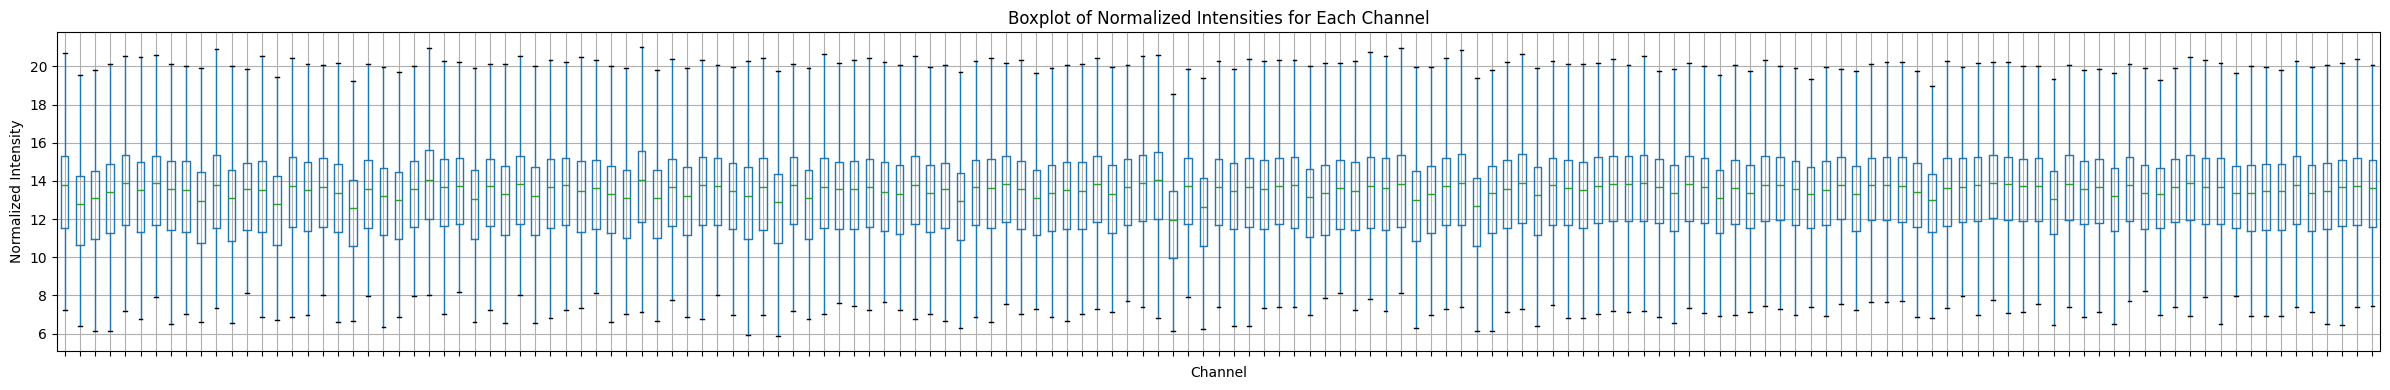

In [19]:
# Check that the normalized data has comparable variability across samples
fig , ax = plt.subplots(figsize=(24, 4))
exp_data.boxplot(rot=90, ax=ax, showfliers=False)
ax.set_title("Boxplot of Normalized Intensities for Each Channel")
ax.set_ylabel("Normalized Intensity")
ax.set_xlabel("Channel")
ax.set(xticklabels=[])
plt.tight_layout()
plt.show()

Text(0.5, 0, 'Normalized Intensity')

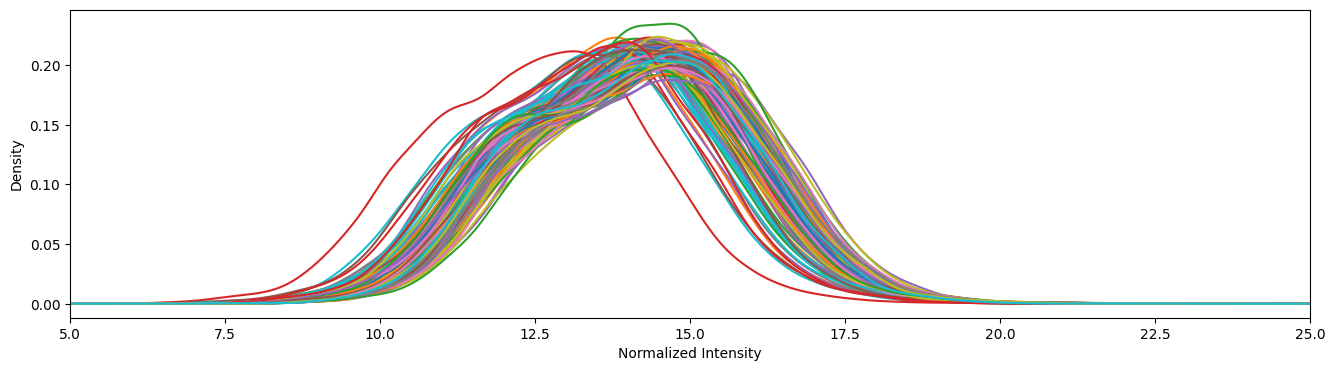

In [20]:
# Density plot for a column of res
fig , ax = plt.subplots( 1 , 1 , figsize=(16, 4) )
for col in exp_data_n.columns:
    s_res = exp_data_n[col][ exp_data_n[col] != 0 ]
    s_res.plot(kind='density', ax=ax )

ax.set_xlim(5,25)
ax.set_xlabel("Normalized Intensity")

The next thing to look at is the protein coverage across samples, as well as proteins detected on each sample


(11914, 153)


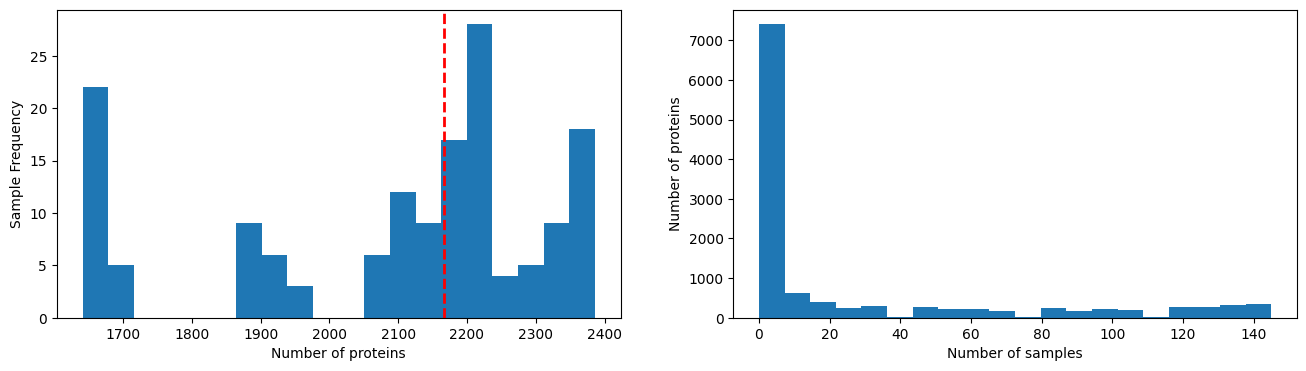

In [21]:
print(exp_data.shape)
fig , ax = plt.subplots( 1 , 2 , figsize=(16, 4) )

(exp_data == 0).sum( axis = 0 ).plot(kind='hist', ax=ax[0] , bins=20 )
(exp_data == 0).sum( axis = 1 ).plot(kind='hist', ax=ax[1] , bins=20 )

ax[0].set_xlabel("Number of proteins")
ax[0].set_ylabel("Sample Frequency")

ax[1].set_xlabel("Number of samples")
ax[1].set_ylabel("Number of proteins")

i = 0
median_val = (exp_data == 0).sum(axis=i).median()
ax[i].axvline(median_val, color='red', linestyle='--', linewidth=2)


### Section Summary:
* There's similar variability across samples in the normalized data
* The median number of protein detected per sample is ca. 2300

# Exploratora Data Analysis

To explore the overall structure un the samples, in terms of possible clusters, we can apply dimensionality reduction techniques such as TSNE

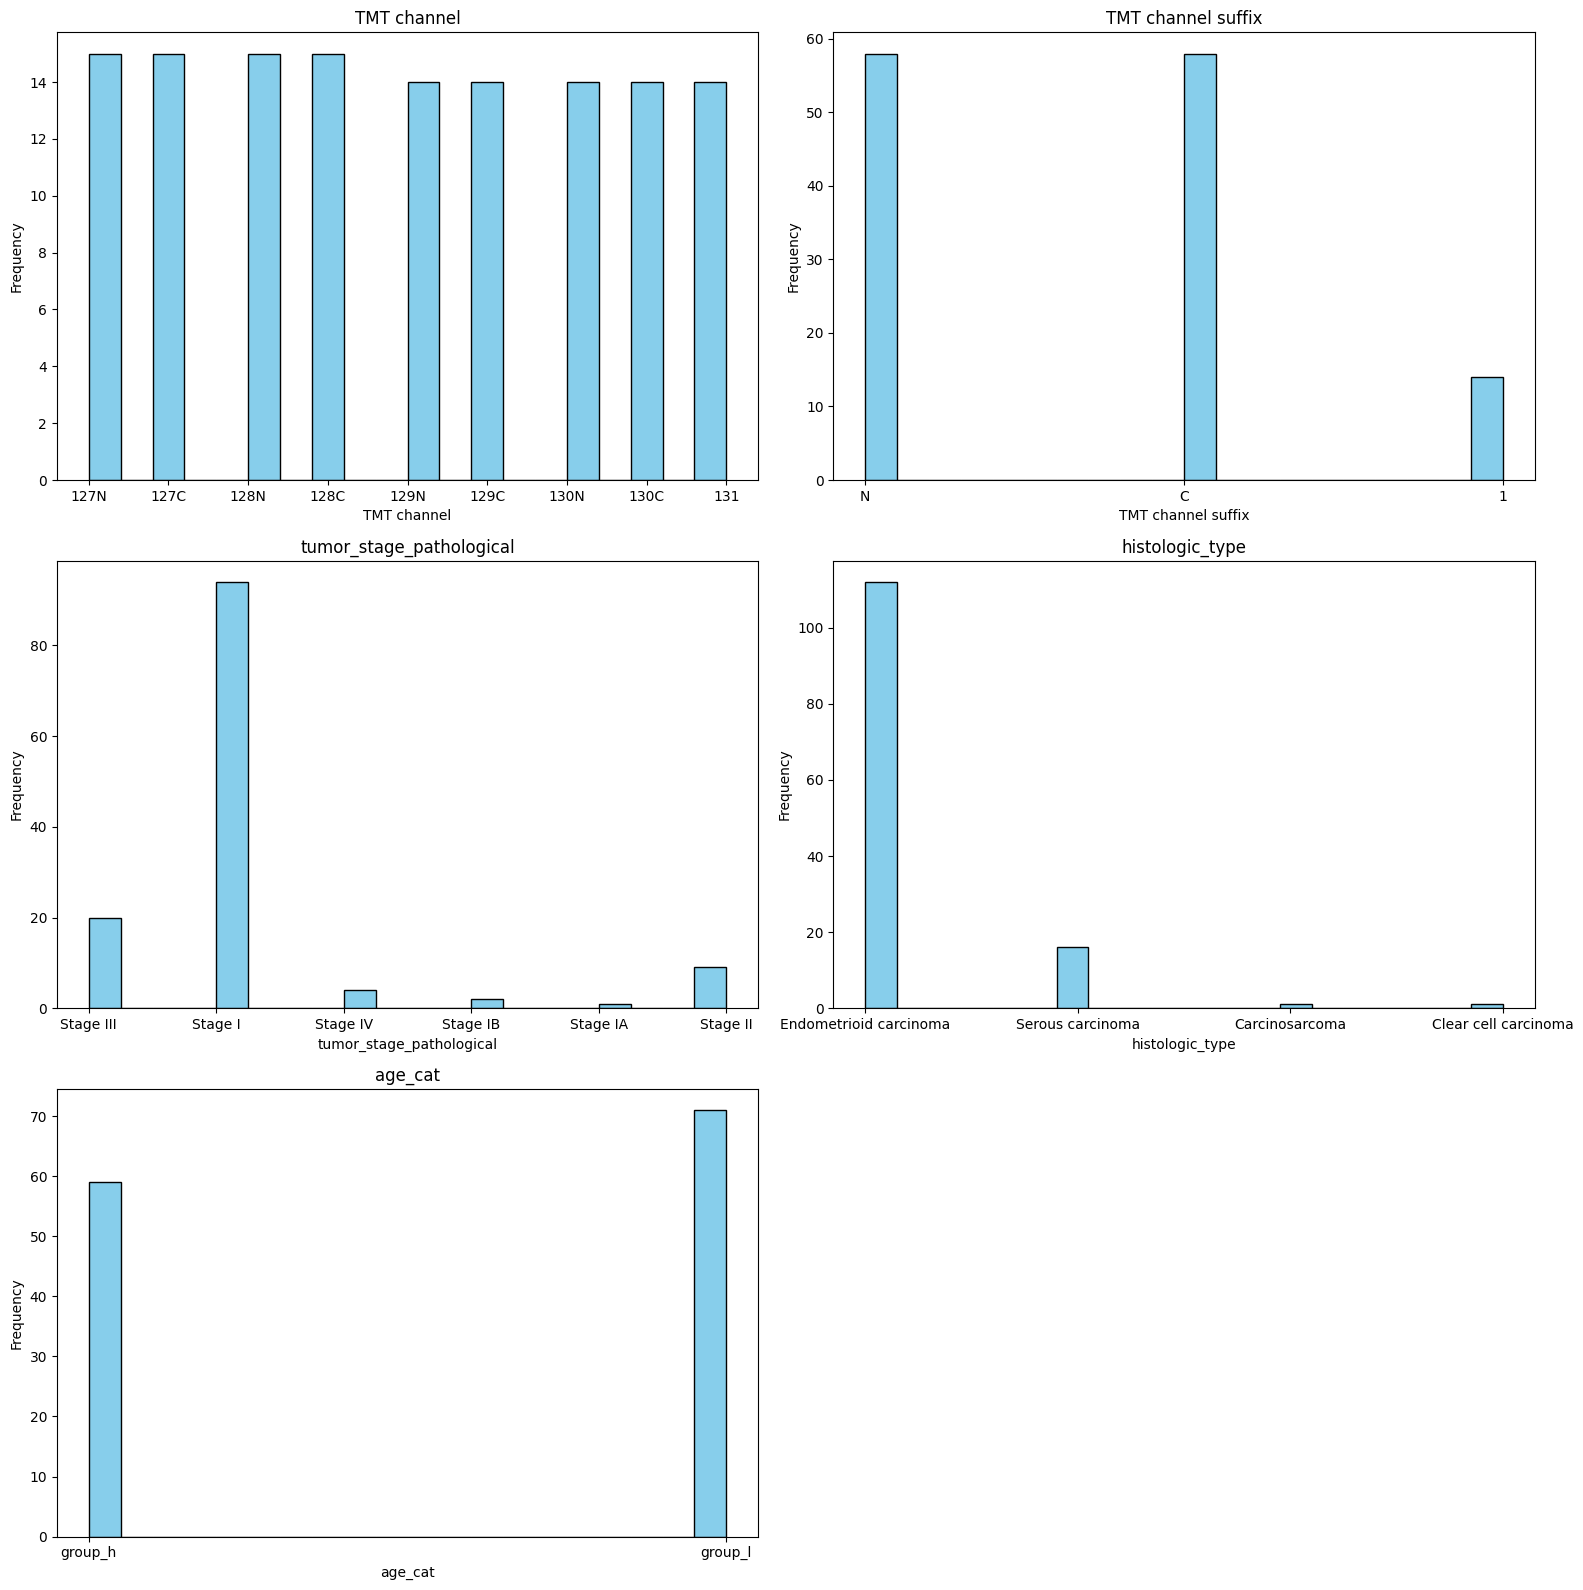

In [22]:
fig, ax = plt.subplots(3, 2, figsize=(16,16))
ax = ax.flatten()

cols = ['TMT channel', 'TMT channel suffix', 'tumor_stage_pathological', 'histologic_type','age_cat']
for i in range(5):
    col_vals = colData[cols[i]]
    ax[i].hist(col_vals, bins=20, color='skyblue', edgecolor='black')
    ax[i].set_title(cols[i])
    ax[i].set_xlabel(cols[i])
    ax[i].set_ylabel('Frequency')
    colors = colData[cols[i]].astype('category').cat.codes

ax[5].axis('off')
plt.tight_layout()
plt.show()

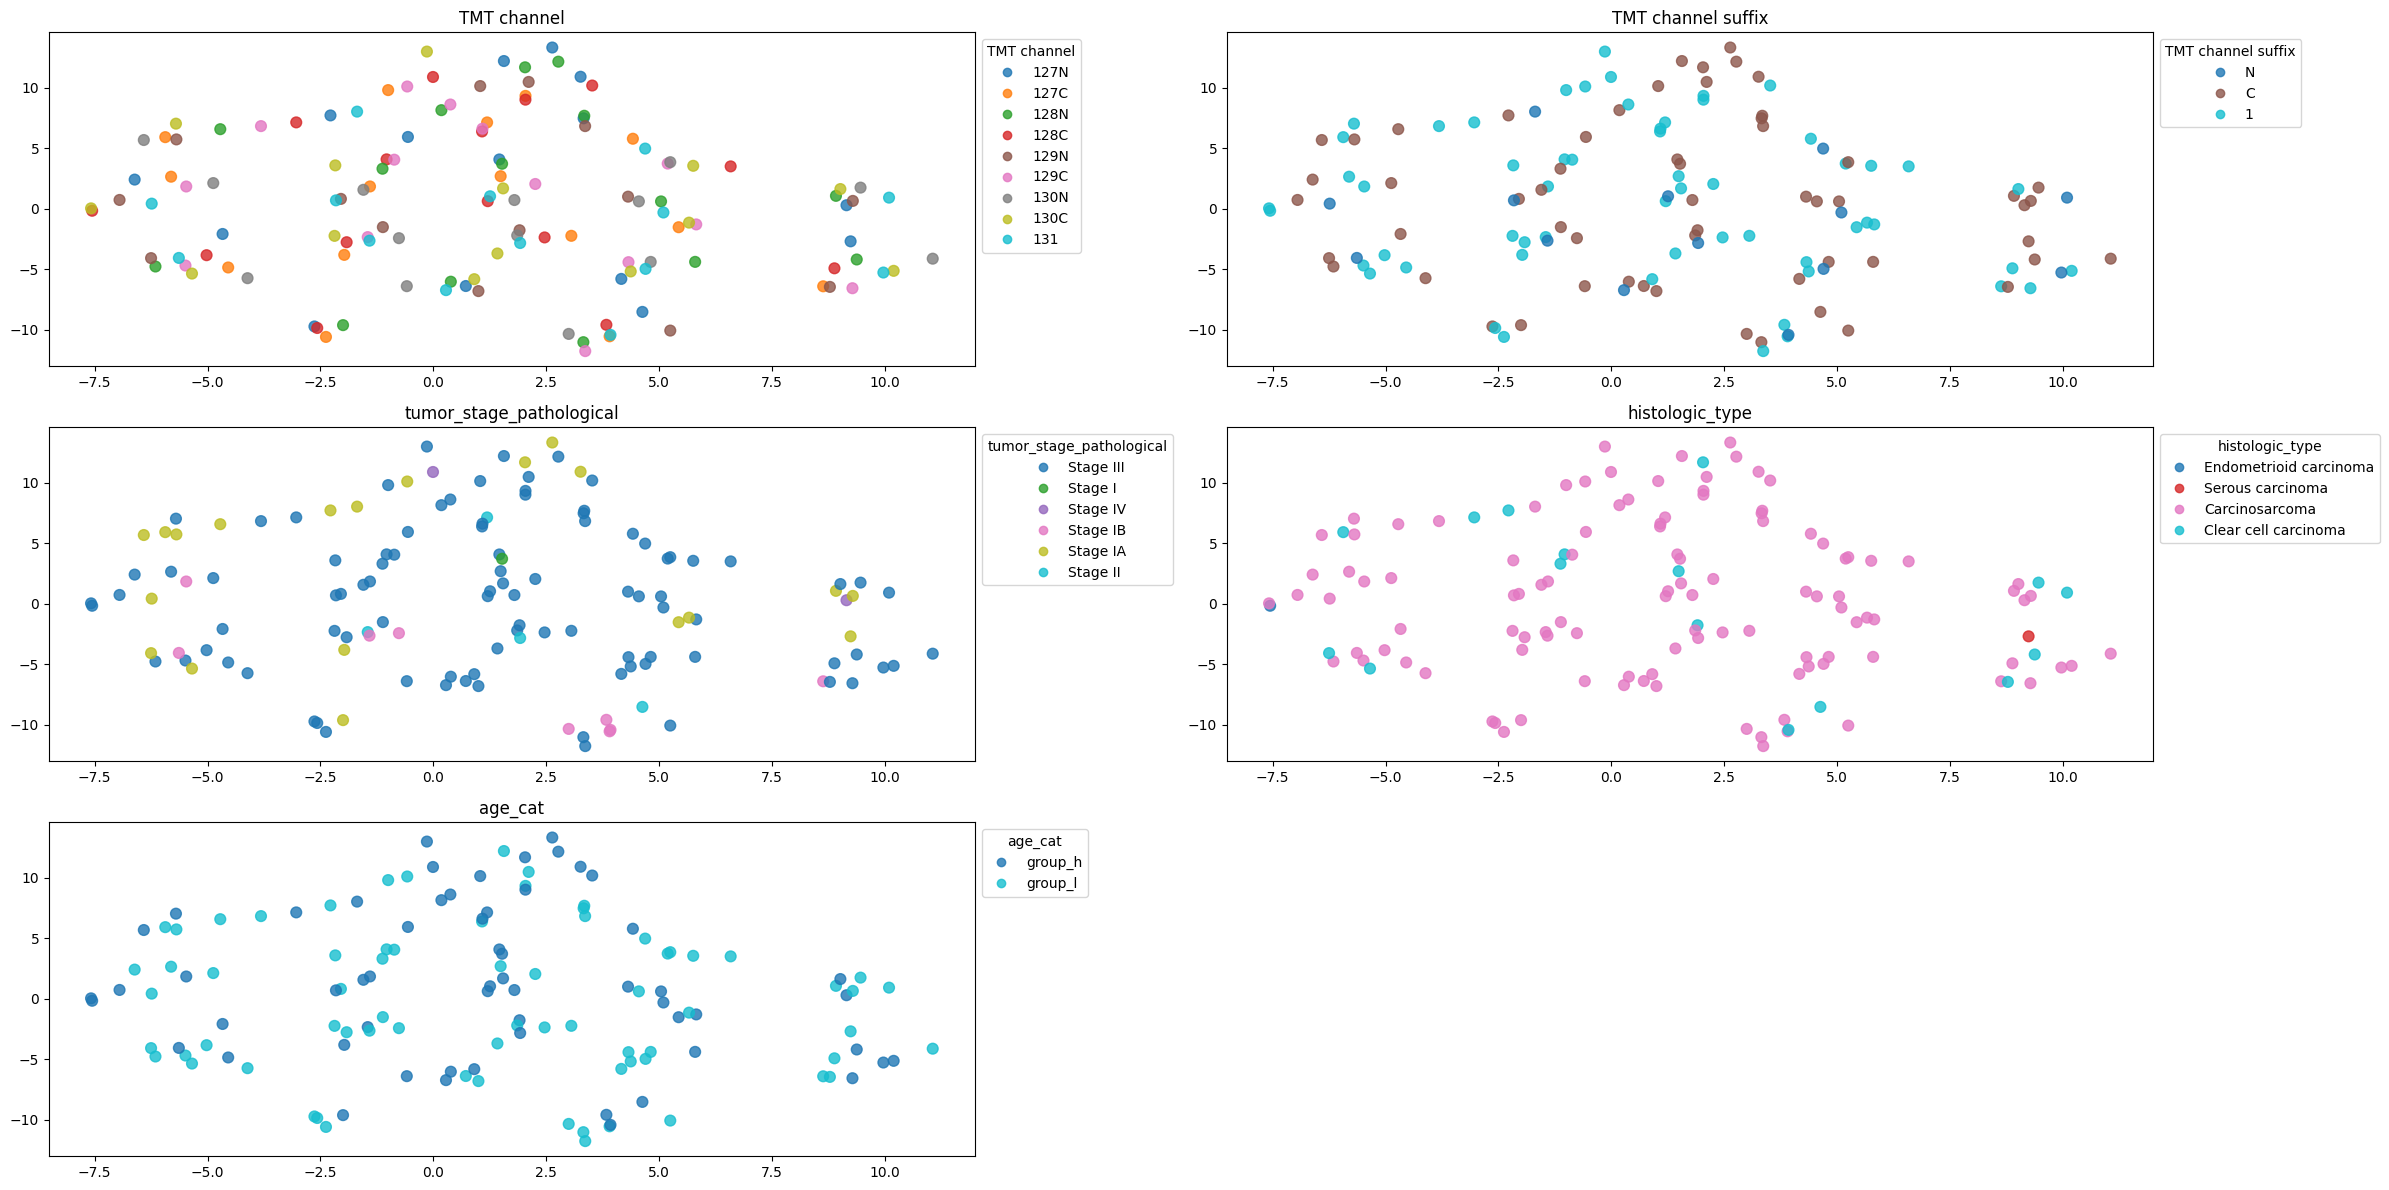

In [23]:
# Standar scale the data
X_scaled = StandardScaler().fit_transform(exp_data_n.T)

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_embedded = tsne.fit_transform(X_scaled)

# Plot t-SNE embedding
fig , ax = plt.subplots( 3 , 2 , figsize=(24, 12) )
ax = ax.flatten()
cols = ['TMT channel', 'TMT channel suffix', 'tumor_stage_pathological', 'histologic_type','age_cat']
for i in range(5):
    colors = colData[cols[i]].astype('category').cat.codes

    scatter = ax[i].scatter(  # use ax[i].scatter instead of plt.scatter
        X_embedded[:, 0],
        X_embedded[:, 1],
        c=colors,
        cmap='tab10',
        s=60,
        alpha=0.8
    )

    # Add legend
    handles, _ = scatter.legend_elements(prop="colors")
    labels = colData[cols[i]].unique()
    ax[i].legend(handles, labels, title=cols[i], loc='upper left', bbox_to_anchor=(1, 1))
    ax[i].set_title(cols[i])

# Remove last  panel
ax[5].axis('off')
plt.tight_layout()
plt.show()

## Clustering of Samples

to measure similarity betwwn sampüles, I will calculate the pearson correlation, and then use those values to do a cluster analysis

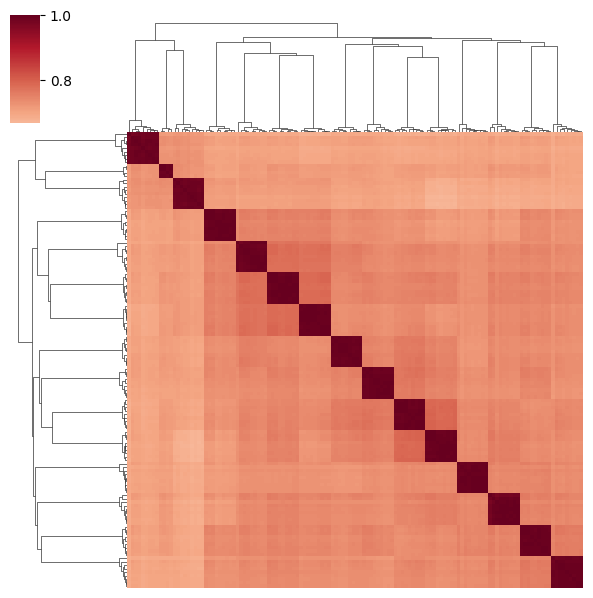

In [24]:
corr_df = exp_data_n.corr()
colData_r = colData.set_index('SampleName').loc[corr_df.columns]
g = sns.clustermap( corr_df , 
    center = 0.5 , 
    cmap = "RdBu_r" , 
    xticklabels = False , 
    yticklabels = False , 
    figsize = (6, 6)
    )

plt.show()

The previous plot shows that there is modest overall similarity across samples. Next I will use the ComplexHeatmap R package to investigate if an 'optimal' number of clusters exist

In [25]:
# Save copies of the expression, correlation & metadata
exp_data_n.to_csv("norm_expression_data.csv")
corr_df.to_csv("correlation_matrix.csv")
colData_r.to_csv("metadata.csv")

Loading required package: grid
ComplexHeatmap version 2.24.1
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))

circlize version 0.4.16
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and

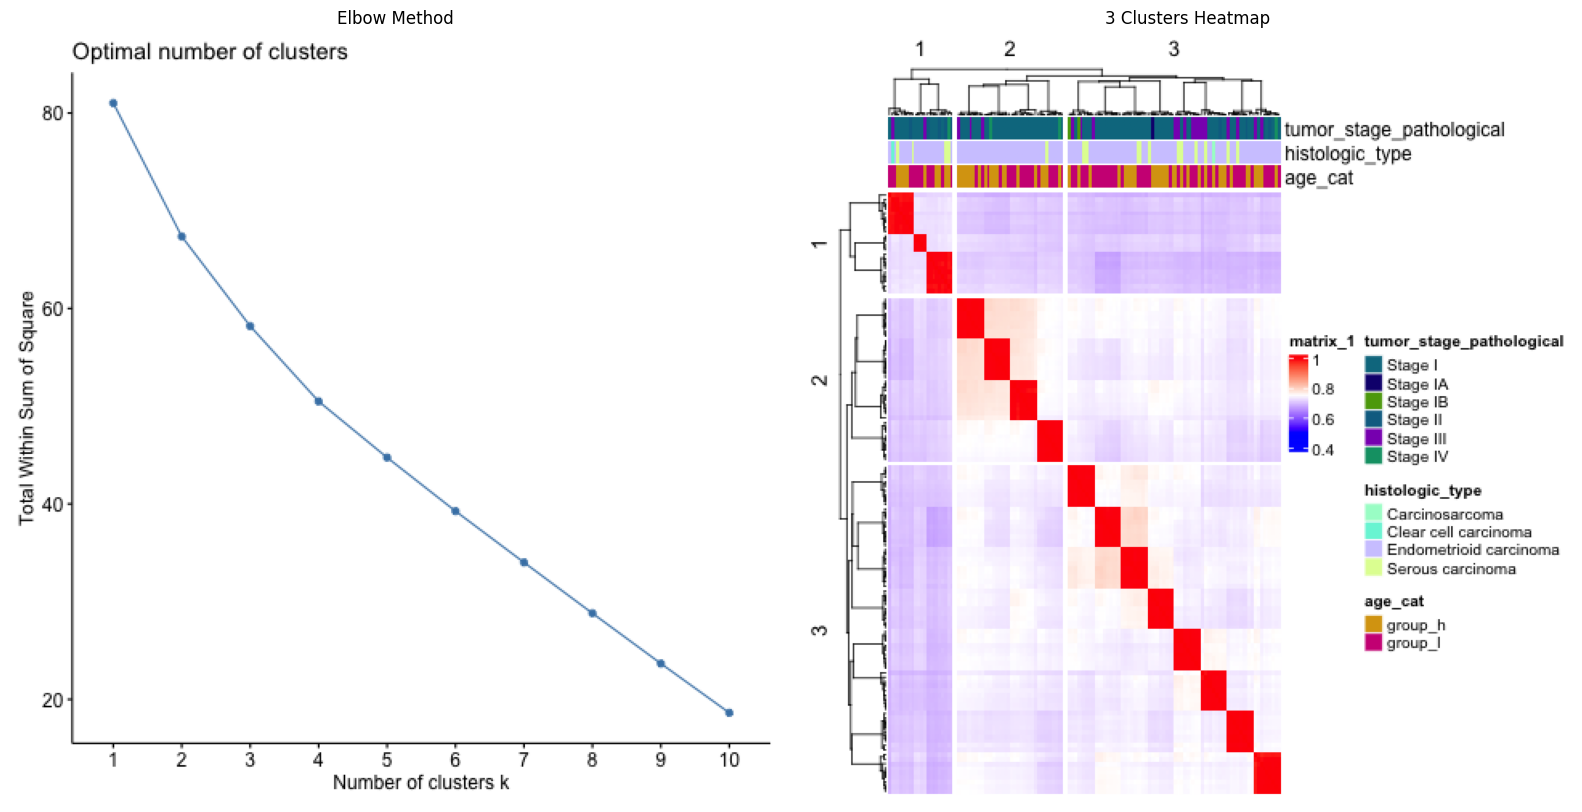

In [26]:
# Generate .png output files
!Rscript --vanilla 02_ComplexHeatmap_clust.R
png_files = ["elbow_method_analysis.png", "3clusters_heatmap.png"]
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
for ax, fname, title in zip(axes, png_files, ["Elbow Method", "3 Clusters Heatmap"]):
    img = plt.imread(fname)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(title)
plt.tight_layout()
plt.show()

* The Elbow method, didn't shpw a clear 'best number of clusters, so to create the heatmap i decided to use 3 clusters
* Although the overall similarity across samples is rather homogeneous within each clsuter there are a few samples that are more correlataed to one another (see white-er squares)

# Differential Abundance Analysis

## Effect of age group on protein abundance

In [27]:
from scipy.stats import ttest_ind

# Prepare group indices based on age_cat
group_h_idx = colData[colData['age_cat'] == 'group_h'].index
group_l_idx = colData[colData['age_cat'] == 'group_l'].index

# Store results
ttest_results = []

for protein_id, row in exp_data_n.iterrows():
    group_h_vals = row.iloc[group_h_idx].values
    group_l_vals = row.iloc[group_l_idx].values

    # Calculate fraction of non-zero values in each group
    frac_nonzero_h = np.mean(group_h_vals != 0)
    frac_nonzero_l = np.mean(group_l_vals != 0)

    # Filter out zero values before calculations
    group_h_nonzero = group_h_vals[group_h_vals != 0]
    group_l_nonzero = group_l_vals[group_l_vals != 0]

    # Calculate log2 fold change using non-zero values
    mean_h = np.mean(group_h_nonzero) if len(group_h_nonzero) > 0 else 0
    mean_l = np.mean(group_l_nonzero) if len(group_l_nonzero) > 0 else 0
    log2fc = np.log2(mean_h + 1e-8) - np.log2(mean_l + 1e-8)

    # Perform t-test using non-zero values
    t_stat, p_val = ttest_ind(group_h_nonzero, group_l_nonzero, nan_policy='omit')

    # Perform t-test
    t_stat, p_val = ttest_ind(group_h_vals, group_l_vals, nan_policy='omit')
    ttest_results.append({
        'protein_id': protein_id,
        't_stat': t_stat,
        'p_value': p_val,
        'frac_nonzero_h': frac_nonzero_h,
        'frac_nonzero_l': frac_nonzero_l,
        'log2FC': log2fc
    })
    # Perform t-test
    t_stat, p_val = ttest_ind(group_h_vals, group_l_vals, nan_policy='omit')
    ttest_results.append({'protein_id': protein_id, 't_stat': t_stat, 'p_value': p_val})

# Convert results to DataFrame
ttest_df = pd.DataFrame(ttest_results).dropna()
ttest_df['abs_log2FC'] = np.abs( ttest_df['log2FC'] )
ttest_df.sort_values(by='p_value', ascending=True,inplace=True)

# Convert ids to Gene names
protein_to_gene = dict( zip( protein_groups.index , protein_groups['Gene names'] ) )
ttest_df['gene_name'] = ttest_df['protein_id'].map(protein_to_gene)
ttest_df.head()

,protein_id,t_stat,p_value,frac_nonzero_h,frac_nonzero_l,log2FC,abs_log2FC,gene_name
16374,Q96C19,-4.376712,0.000025,1.0,1.0,-0.026141,0.026141,EFHD2
6714,P49407;P10523,-4.127785,0.000066,1.0,1.0,-0.021901,0.021901,ARRB1
7356,P55008,-3.946914,0.000130,1.0,1.0,-0.032099,0.032099,AIF1
17466,Q96RU3,-3.762697,0.000255,1.0,1.0,-0.019902,0.019902,FNBP1
7950,P62993,-3.754225,0.000263,1.0,1.0,-0.017017,0.017017,GRB2


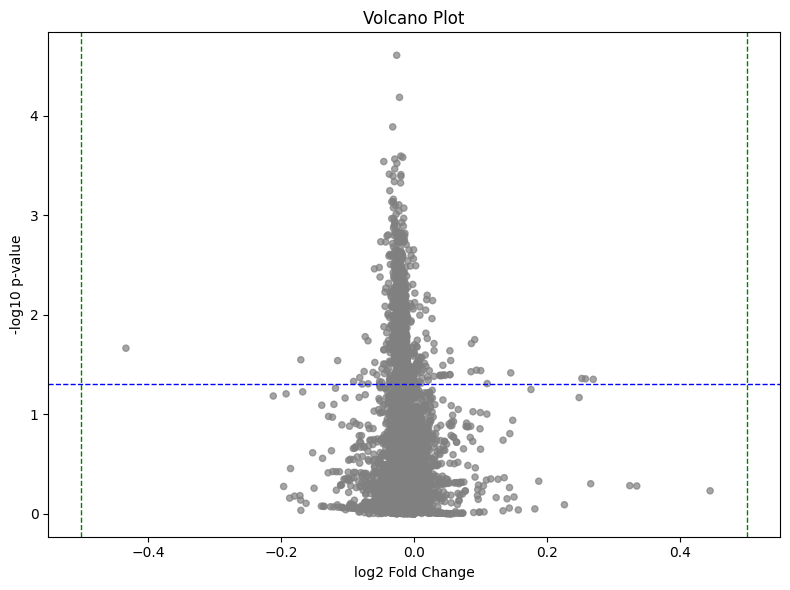

In [28]:
def plot_volcano(ttest_df, pval_thresh=0.05, log2fc_thresh=0.5):
    fig, ax = plt.subplots(figsize=(8, 6))
    # -log10 p-value
    ttest_df['neg_log10_p'] = -np.log10(ttest_df['p_value'])
    # Color by significance
    sig = (ttest_df['p_value'] < pval_thresh) & (ttest_df['abs_log2FC'] > log2fc_thresh)
    ax.scatter(ttest_df['log2FC'], ttest_df['neg_log10_p'], 
               c=sig.map({True: 'red', False: 'grey'}), alpha=0.7, s=20)
    ax.axhline(-np.log10(pval_thresh), color='blue', linestyle='--', linewidth=1)
    ax.axvline(log2fc_thresh, color='green', linestyle='--', linewidth=1)
    ax.axvline(-log2fc_thresh, color='green', linestyle='--', linewidth=1)
    ax.set_xlabel('log2 Fold Change')
    ax.set_ylabel('-log10 p-value')
    ax.set_title('Volcano Plot')
    plt.tight_layout()
    plt.show()
    
plot_volcano(ttest_df)
    

For the previous analysis, I used the patients age  and divided into two (high vs low group) based on the median age and the t-tes comparison has High vs Low. In doing so, a few proteins are found with a pvalue < 0.05 . However, all of their log2Fc are very small. thus indicating that the 'biology' of the canncer in between these two groups is similar

## Effect of **tumor_stage** on protein abundance

In [29]:
from scipy.stats import kruskal
# Prepare group indices based on tumor_stage_pathological
stage_groups = colData.groupby('tumor_stage_pathological').groups

# Store Kruskal-Wallis results
kruskal_results = []

for protein_id, row in exp_data_n.iterrows():
    # Gather values for each stage group
    group_vals = [row.iloc[idx].values for idx in stage_groups.values()]
    # Only test if at least two groups have non-zero values
    nonzero_counts = [np.sum(vals != 0) for vals in group_vals]
    if sum([count > 0 for count in nonzero_counts]) >= 2:
        # Remove zero values from each group
        group_vals_nonzero = [vals[vals != 0] for vals in group_vals]
        # Only keep groups with non-zero values
        group_vals_nonzero = [vals for vals in group_vals_nonzero if len(vals) > 0]
        if len(group_vals_nonzero) >= 2:
            stat, p_val = kruskal(*group_vals_nonzero)
        else:
            stat, p_val = np.nan, np.nan
    else:
        stat, p_val = np.nan, np.nan

    # calculate effect size
    N = len(exp_data_n)
    eta_sq = stat / (N - 1) if N > 1 else 0
    kruskal_results.append({
        'protein_id': protein_id,
        'kruskal_stat': stat,
        'p_value': p_val,
        'eta_squared': eta_sq   
    })

# Convert results to DataFrame
kruskal_df = pd.DataFrame(kruskal_results).dropna()
kruskal_df.sort_values(by='eta_squared', ascending=False, inplace=True)

# Convert ids to Gene names
kruskal_df['gene_name'] = kruskal_df['protein_id'].map(protein_to_gene)

# Bonferroni adjustment for multiple hypothesis testing
kruskal_df['p_adj'] = kruskal_df['p_value'] * len(kruskal_df)
kruskal_df['p_padj'] = kruskal_df['p_adj'].clip(upper=1.0)
display(kruskal_df.head())
display(kruskal_df.tail())


,protein_id,kruskal_stat,p_value,eta_squared,gene_name,p_adj,p_padj
2840,P29373,19.625052,0.001469,0.001647,CRABP2,17.311630,1.0
1727,P02792,18.337762,0.002552,0.001539,FTL,30.065101,1.0
8344,Q96FJ0,18.201990,0.002704,0.001528,STAMBPL1,31.856792,1.0
11219,Q9Y259,17.752831,0.003273,0.001490,CHKB,38.561905,1.0
2920,P31513,17.000259,0.000707,0.001427,FMO3,8.326524,1.0


,protein_id,kruskal_stat,p_value,eta_squared,gene_name,p_adj,p_padj
8419,Q96HA9,0.0,1.0,0.0,PEX11G,11783.0,1.0
2906,P31025;Q5VSP4,0.0,1.0,0.0,LCN1;LCN1P1,11783.0,1.0
1476,O95620,0.0,1.0,0.0,DUS4L,11783.0,1.0
1523,O95841,0.0,1.0,0.0,ANGPTL1,11783.0,1.0
6177,Q6UXA7,0.0,1.0,0.0,C6orf15,11783.0,1.0


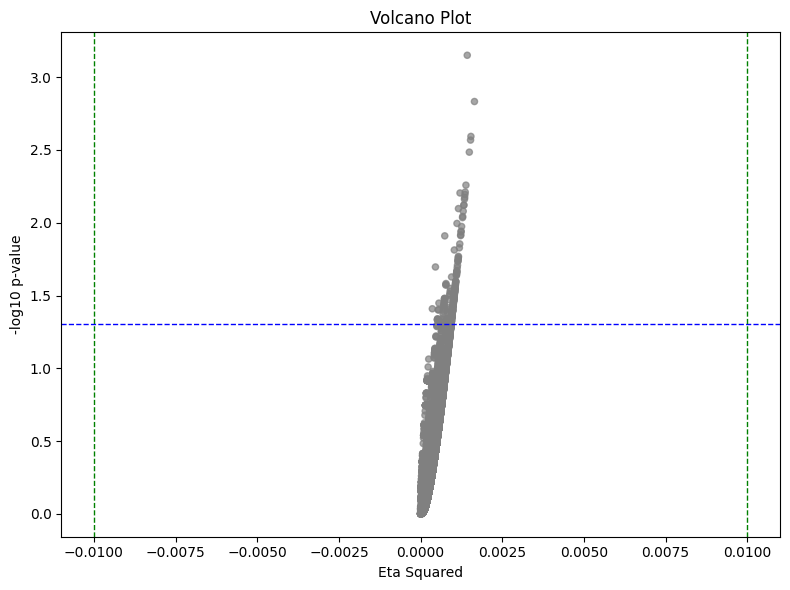

In [30]:
def plot_volcano_kruskal(kruskal_df, pval_thresh=0.05, eta_thresh=0.01):
    fig, ax = plt.subplots(figsize=(8, 6))
    # -log10 p-value
    kruskal_df['neg_log10_p'] = -np.log10(kruskal_df['p_value'])
    # Color by significance
    sig = (kruskal_df['p_value'] < pval_thresh) & (kruskal_df['eta_squared'] > eta_thresh)
    ax.scatter(kruskal_df['eta_squared'], kruskal_df['neg_log10_p'], 
               c=sig.map({True: 'red', False: 'grey'}), alpha=0.7, s=20)
    ax.axhline(-np.log10(pval_thresh), color='blue', linestyle='--', linewidth=1)
    ax.axvline(eta_thresh, color='green', linestyle='--', linewidth=1)
    ax.axvline(-eta_thresh, color='green', linestyle='--', linewidth=1)
    ax.set_xlabel('Eta Squared')
    ax.set_ylabel('-log10 p-value')
    ax.set_title('Volcano Plot')
    plt.tight_layout()
    plt.show()

plot_volcano_kruskal(kruskal_df)